# Examples of tuning SVMs with multiple metrics

This is an example of using multimetric optimization to consider the tradeoff between certain concerns (speed and accuracy) when tuning a support vector machine.  If you have not yet done so, please make sure you are comfortable with the content in the [intro](multimetric_intro.ipynb) notebook.

In [1]:
import numpy
import os
import pandas
import urllib

from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.svm import SVC
from time import time as now

from matplotlib import pyplot as plt
%matplotlib inline

# Matplotlib stuff for generating plots
dominated_opts = {'linewidth': 0, 'marker': '.', 'color': 'k', 'alpha': .4}
efficient_opts = {'linewidth': 0, 'marker': '+', 'color': 'r', 'markersize': 10, 'markeredgewidth': 2}

from sigopt.interface import Connection

if 'SIGOPT_API_TOKEN' in os.environ:
    SIGOPT_API_TOKEN = os.environ['SIGOPT_API_TOKEN']
else:
    SIGOPT_API_TOKEN = None

assert SIGOPT_API_TOKEN is not None
conn = Connection(client_token=SIGOPT_API_TOKEN)

We define here a function to let us read in data.  This function works on most of the [UCI data sets](https://archive.ics.uci.edu/ml/datasets.html) which is why it is more complicated than it needs to be: it handles categorical values in a one-hot fashion and manages missing data by averaging the missing values.  It also has options to normalize all numerical inputs to a [0, 1] domain (a useful normalization for support vector machines) and split input data into a test and training set.

In [2]:
def basic_readin_categorical_data(filename, cat_var_indexes, num_var_indexes, val_index, test_split_frac=.2, pandas_kwargs=None, scale01=True):
    pandas_kwargs = pandas_kwargs or {'header': None, 'skipinitialspace': True}
    a = pandas.read_csv(filename, **pandas_kwargs)
    a = a.fillna('?')
    pmat = a.as_matrix()
    
    if numpy.any(pmat[:, val_index] == '?'):  # Cut data with no classification (why is it even there?)
        pmat = numpy.delete(pmat, numpy.where(pmat[:, val_index] == '?')[0], axis=0)

    all_vals = set(pmat[:, val_index])
    val_map = dict(zip(all_vals, range(len(all_vals))))
    vals = numpy.array(map(lambda x: val_map[x], pmat[:, val_index]))

    bad_numerical_indexes = []
    for k in num_var_indexes:
        if sum([v == '?' for v in pmat[:, k]]):
            bad_numerical_indexes.append(k)
    for k in bad_numerical_indexes:
        mean_replace = numpy.mean([float(v) for v in pmat[:, k] if v != '?'])
        print 'Replacing column {0} ? with {1}'.format(k, mean_replace)
        numpy.place(pmat[:, k], pmat[:, k] == '?', mean_replace)

    one_hot_vars = [pandas.get_dummies(pmat[:, k]) for k in cat_var_indexes]
    num_vars = pmat[:, num_var_indexes].astype(float)
    data = numpy.concatenate([num_vars] + one_hot_vars, axis=1)
    if scale01:
        l = numpy.min(data, axis=0)
        u = numpy.max(data, axis=0)
        data -= l[numpy.newaxis, :]
        data /= (abs(u[numpy.newaxis, :] - l[numpy.newaxis, :]) + 1e-16)
    if test_split_frac:
        return train_test_split(data, vals, test_size=test_split_frac)
    else:
        return data, vals

The problem under consideration here is a classification problems using data from the UCI database, in particular the [telescope](https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope) dataset.

First, we download the data from the UCI server, if it does not already exist in this directory.  Using the function above, read in and store the data, and then split up into training and test sets.

In [3]:
if not os.path.isfile('magic04.data'):
    urllib.urlretrieve('https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data', 'magic04.data')

cat_var_indexes = []
num_var_indexes = list(range(10))
val_index = 10
train_test_data = basic_readin_categorical_data('magic04.data', cat_var_indexes, num_var_indexes, val_index)

Here we create an iterator that splits our data randomly into cross-validation folds (subtrain and validation sets).  The `validate_frac` value determines the proportion of the training data which is randomly placed in the validation set (with the rest going to the subtrain set).  This closely resembles the [ShuffleSplit](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit) cross-validation tool in scikit-learn, but the splits are not i.i.d. because each element is guaranteed to appear in at least one validation set per `ceil(1 / validation_frac)` consecutive folds.

In [4]:
def cv_iterator(train_data, train_vals, n_folds, validate_frac=.25):
    n_data = len(train_data)
    list_of_values = list(range(n_data))
    num_folds_executed = 0
    leftover_indices = set([])
    while num_folds_executed < n_folds:
        possible_remaining_indices = set(list_of_values)
        returned_validate_indices = set([])
        
        for _ in range(int(numpy.ceil(1 / validate_frac))):
            if num_folds_executed >= n_folds:  # If n_folds is less than 1 / validate_frac, this stops after n_folds
                break
                
            validate_indices = numpy.array([], dtype=int)
            if leftover_indices:
                validate_indices = numpy.array(list(leftover_indices))
                possible_remaining_indices -= leftover_indices
                leftover_indices = set([])
                
            validate_indices = numpy.append(validate_indices, numpy.random.choice(list(possible_remaining_indices), replace=False, size=int(validate_frac * n_data) - len(validate_indices)))
            returned_validate_indices |= set(validate_indices)
            possible_remaining_indices -= set(validate_indices)
            subtrain_indices = numpy.array(list(set(list_of_values) - set(validate_indices)), dtype=int)

            num_folds_executed += 1
            subtrain_data, subtrain_vals = train_data[subtrain_indices], train_vals[subtrain_indices]
            validate_data, validate_vals = train_data[validate_indices], train_vals[validate_indices]
            yield subtrain_data, subtrain_vals, validate_data, validate_vals
        
        leftover_indices = possible_remaining_indices

We define the metrics that we want to study as

* the average of the cross-validated scores, and
* the average of the time required to train each of them.

We also report an estimate of the standard deviation for both of these quantities.  Note that, because we (presumably) want to minimize the training time, we will negate that value in observations.

The [parameters of interest](http://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html) in this problem are

* $\gamma$ - the [shape parameter](https://www.siam.org/students/siuro/vol4/S01084.pdf) of the RBF kernel in the SVM
* $C$ - the [box constraint](https://en.wikipedia.org/wiki/Support_vector_machine#Properties), balancing slack in a soft-margin SVM

Both of these are optimized on a log-scale, thus the `log_` out front.

In [5]:
svm_score_time_meta = {
    'name': 'SigOpt Multimetric Demo - Balancing Score vs. Training Time (python)',
    'project': 'sigopt-examples',
    'metrics': [
        {'name': 'score'},
        {'name': 'training time'},
    ],
    'parameters': [
        {'name': 'log_gamma', 'bounds': {'min': numpy.log(.01), 'max': numpy.log(100)}, 'type': 'double'},
        {'name': 'log_C', 'bounds': {'min': numpy.log(.01), 'max': numpy.log(100)}, 'type': 'double'},
    ],
    'type': 'offline',
    'observation_budget': 111,
}

We create a function which will return a dictionary full of the necessary information to create an observation, given a suggestion from SigOpt.  This is not required, but it helps simplify the optimization loop.  Recall, we are negating the training time to try to minimize (not maximize) it.  Also, notice the use of `numpy.exp` to move the parameters given by SigOpt from log-scale to the appropriate domain values needed in scikit-learn.

We also want to report, as metadata, the error on the test data set, just to keep relevant information altogether.  In practice, it may be the case that this quantity will only be computed after the optimization is completed.

Note that, for the time being, [cross-validated experiment types](https://sigopt.com/docs/overview/cross_validated) are **not** permitted to have multiple metrics.  As such, the cross-validation reduction is managed here rather than within SigOpt.

In [6]:
def form_score_time_observation_dict(suggestion, train_test_data, num_folds=5):
    (train_data, test_data, train_vals, test_vals) = train_test_data
    sklearn_tool = SVC(
        C=numpy.exp(suggestion.assignments['log_C']),
        gamma=numpy.exp(suggestion.assignments['log_gamma']),
    )
    
    all_training_times = []
    all_training_scores = []
    for subtrain_data, subtrain_vals, validate_data, validate_vals in cv_iterator(train_data, train_vals, num_folds):
        start = now()
        sklearn_tool.fit(subtrain_data, subtrain_vals)
        end = now()
        all_training_times.append(float(end - start))
        all_training_scores.append(sklearn_tool.score(validate_data, validate_vals))
        
    start = now()
    sklearn_tool.fit(train_data, train_vals)
    end = now()
    test_time = end - start
    test_score = sklearn_tool.score(test_data, test_vals)
    
    observation_dict = {
        'suggestion': suggestion.id,
        'values': [
            {
                'name': 'score',
                'value': numpy.mean(all_training_scores),
                'value_stddev': numpy.sqrt(numpy.var(all_training_scores) / num_folds)
            },
            {
                'name': 'training time',
                'value': -numpy.mean(all_training_times),
                'value_stddev': numpy.sqrt(numpy.var(all_training_times) / num_folds)
            },
        ],
        'metadata': {
            'num_folds': num_folds,
            'test_score': test_score,
            'test_time': test_time,
        },
    }
    return observation_dict

Create the experiment and execute the optimization loop.

In [7]:
experiment = conn.experiments().create(**svm_score_time_meta)

In [8]:
while experiment.progress.observation_count < experiment.observation_budget:
    suggestion = conn.experiments(experiment.id).suggestions().create()
    observation = form_score_time_observation_dict(suggestion, train_test_data)
    conn.experiments(experiment.id).observations().create(**observation)
    experiment = conn.experiments(experiment.id).fetch()

Extract the [Pareto efficient](https://en.wikipedia.org/wiki/Pareto_efficiency) points for analysis.  See [our documentation](https://www.sigopt.com/docs/overview/pareto_efficiency) for more discussion on this topic.  We also recover all the dominated points that were sampled, for completeness.

In [9]:
pareto_efficient_results = conn.experiments(experiment.id).best_assignments().fetch()
efficient_points = numpy.empty((pareto_efficient_results.count, 2))
efficient_values = numpy.empty((pareto_efficient_results.count, 2))
for k, data in enumerate(pareto_efficient_results.data):
    efficient_points[k, :] = [data.assignments['log_gamma'], data.assignments['log_C']]
    dv = {d.name: d.value for d in data.values}
    efficient_values[k, :] = [dv[m['name']] for m in svm_score_time_meta['metrics']]
    
all_points = numpy.empty((experiment.progress.observation_count, 2))
all_values = numpy.empty((experiment.progress.observation_count, 2))
for k, obs in enumerate(conn.experiments(experiment.id).observations().fetch().iterate_pages()):
    all_points[k, :] = [obs.assignments['log_gamma'], obs.assignments['log_C']]
    ov = {o.name: o.value for o in obs.values}
    all_values[k, :] = [ov[m['name']] for m in svm_score_time_meta['metrics']]

Plot the results from the optimization and try to make a judgment as to which points are considered most desirable.  In this particular experiment, the goal is mainly to understand the relationship between training time and quality; a specific decision would have to be made in some larger business context.

It should also be noted that, in a practical setting, the timing information should be drawn from the computer on which the actual production training will take place, not a development computer.

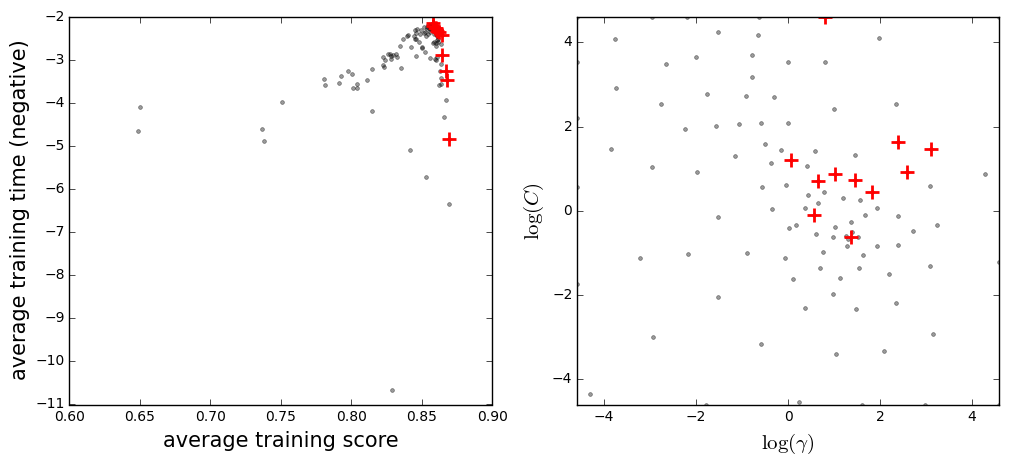

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(all_values[:, 0], all_values[:, 1], **dominated_opts)
ax1.plot(efficient_values[:, 0], efficient_values[:, 1], **efficient_opts)
ax1.set_xlabel('average training score', fontsize=15)
ax1.set_ylabel('average training time (negative)', fontsize=15)

ax2.plot(all_points[:, 0], all_points[:, 1], **dominated_opts)
ax2.plot(efficient_points[:, 0], efficient_points[:, 1], **efficient_opts)
ax2.set_xlabel('$\log(\gamma)$', fontsize=15)
ax2.set_ylabel('$\log(C)$', fontsize=15)
ax2.set_xlim(svm_score_time_meta['parameters'][0]['bounds']['min'], svm_score_time_meta['parameters'][0]['bounds']['max']);
ax2.set_ylim(svm_score_time_meta['parameters'][1]['bounds']['min'], svm_score_time_meta['parameters'][1]['bounds']['max']);

It may help somewhat to zoom in on the efficient points so as to better resolve the spread of efficient outcomes.

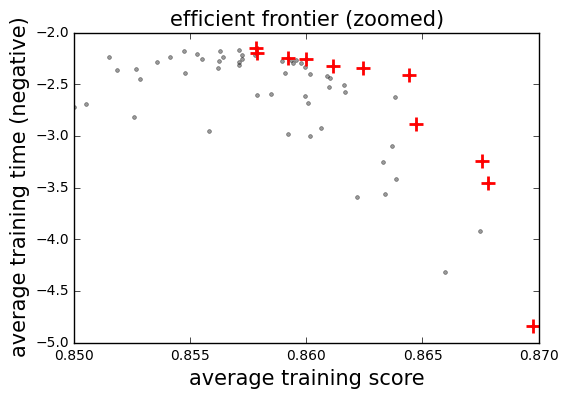

In [11]:
plt.plot(all_values[:, 0], all_values[:, 1], **dominated_opts)
plt.plot(efficient_values[:, 0], efficient_values[:, 1], **efficient_opts)
plt.title('efficient frontier (zoomed)', fontsize=15)
plt.xlabel('average training score', fontsize=15)
plt.ylabel('average training time (negative)', fontsize=15)
plt.xlim((.85, .87))
plt.ylim((-5, -2));